In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from grand_slam_qf import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import TomekLinks,OneSidedSelection, RandomUnderSampler



/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def extract_qf_points(matches_df, points_df, qf_players):
    qf_match_ids = matches_df[
        matches_df['player1'].isin(qf_players) & matches_df['player2'].isin(qf_players)
    ]['match_id'].unique()
    return points_df[points_df['match_id'].isin(qf_match_ids)]




In [3]:
def get_df_from_csv(csv):
    return pd.read_csv(csv) 

## Get data and pre-process

In [4]:
matchesdf_wimbledon18 = get_df_from_csv("2018-wimbledon-matches.csv")
pointsdf_wimbledon18 = get_df_from_csv("2018-wimbledon-points.csv")

matchesdf_wimbledon19 = get_df_from_csv("2019-wimbledon-matches.csv")
pointsdf_wimbledon19 = get_df_from_csv("2019-wimbledon-points.csv")

matchesdf_wimbledon21 = get_df_from_csv("2021-wimbledon-matches.csv")
pointsdf_wimbledon21 = get_df_from_csv("2021-wimbledon-points.csv")

matchesdf_wimbledon22 = get_df_from_csv("2022-wimbledon-matches.csv")
pointsdf_wimbledon22 = get_df_from_csv("2022-wimbledon-points.csv")

pointsdf_wimbledon23 = get_df_from_csv("2023-wimbledon-points.csv")

/var/folders/h9/ww6bv2_56t3_2t6n6zljbkr40000gn/T/ipykernel_50941/3146160397.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv)


Extract Quartefinals onwards matches

In [5]:
# qf_points_usopen2018 = extract_qf_points(matchesdf_us18, pointsdf_us18, qf_usopen_2018)
qf_match_ids_2018 = [f"2018-wimbledon-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_wimbledon2018 = pointsdf_wimbledon18[pointsdf_wimbledon18['match_id'].isin(qf_match_ids_2018)]
qf_match_ids_2019 = [f"2019-wimbledon-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_wimbledon2019 = pointsdf_wimbledon19[pointsdf_wimbledon19['match_id'].isin(qf_match_ids_2019)]#using match_ids
qf_match_ids_2021 = [f"2021-wimbledon-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_wimbledon2021 = pointsdf_wimbledon21[pointsdf_wimbledon21['match_id'].isin(qf_match_ids_2021)]
# qf_points_wimbledon2022 = extract_qf_points(matchesdf_wimbledon22, pointsdf_wimbledon22, qf_wimbledon_2022)
qf_match_ids_2022 = [f"2022-wimbledon-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_wimbledon2022 = pointsdf_wimbledon22[pointsdf_wimbledon22['match_id'].isin(qf_match_ids_2022)]
qf_points_wimbledon2023 = pointsdf_wimbledon23[pointsdf_wimbledon23['match_id'].isin(qf_match_ids_2023 := [f"2023-wimbledon-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']])]
print(qf_points_wimbledon2021.shape)
# print(qf_points_wimbledon2019.columns)


(1648, 65)


In [6]:
def drop_nan_columns(grandslam_points):
    nan_col = grandslam_points.columns[grandslam_points.isna().all()]
    grandslam_points = grandslam_points.drop(columns=nan_col)
    return grandslam_points
def drop_redundant_col (grandslam_points):
    grandslam_points = grandslam_points.drop(columns=['ElapsedTime', 'SetNo', 'GameNo', 'Speed_MPH','History'])
    return grandslam_points

## Data Preprocessing

In [7]:
# Drop columns that are all NaN
qf_points_wimbledon2018_cleaned = drop_nan_columns(qf_points_wimbledon2018)
qf_points_wimbledon2018_cleaned = drop_redundant_col(qf_points_wimbledon2018_cleaned)
qf_points_wimbledon2019_cleaned = drop_nan_columns(qf_points_wimbledon2019)
qf_points_wimbledon2019_cleaned = drop_redundant_col(qf_points_wimbledon2019_cleaned)
# qf_points_wimbledon2020_cleaned = drop_nan_columns(qf_points_wimbledon2020)   
# qf_points_usopen2020_cleaned = drop_redundant_col(qf_points_usopen2020_cleaned)
qf_points_wimbledon2021_cleaned = drop_nan_columns(qf_points_wimbledon2021)
qf_points_wimbledon2021_cleaned = drop_redundant_col(qf_points_wimbledon2021_cleaned)
qf_points_wimbledon2022_cleaned = drop_nan_columns(qf_points_wimbledon2022)
qf_points_wimbledon2022_cleaned = drop_redundant_col(qf_points_wimbledon2022_cleaned)
qf_points_wimbledon2023_cleaned = drop_nan_columns(qf_points_wimbledon2023)
qf_points_wimbledon2023_cleaned = drop_redundant_col(qf_points_wimbledon2023_cleaned)
# print(qf_points_wimbledon2022_cleaned.columns)
# print(f"Total columns in qf_points_wimbledon2022_cleaned: {qf_points_wimbledon2022_cleaned.shape[1]}")

In [8]:
qf_points_wimbledon2018_cleaned['IsWinner'] = (qf_points_wimbledon2018_cleaned['WinnerType'] == 'S') | (qf_points_wimbledon2018_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Wimbledon 2018")
print(qf_points_wimbledon2018_cleaned['IsWinner'].value_counts())
qf_points_wimbledon2019_cleaned['IsWinner'] = (qf_points_wimbledon2019_cleaned['WinnerType'] == 'S') | (qf_points_wimbledon2019_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Wimbledon 2019")
print(qf_points_wimbledon2019_cleaned['IsWinner'].value_counts())
qf_points_wimbledon2021_cleaned['IsWinner'] = (qf_points_wimbledon2021_cleaned['WinnerType'] == 'S') | (qf_points_wimbledon2021_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Wimbledon 2021")
print(qf_points_wimbledon2021_cleaned['IsWinner'].value_counts())
qf_points_wimbledon2022_cleaned['IsWinner'] = (qf_points_wimbledon2022_cleaned['WinnerType'] == 'S') | (qf_points_wimbledon2022_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Wimbledon 2022")
print(qf_points_wimbledon2022_cleaned['IsWinner'].value_counts())
qf_points_wimbledon2023_cleaned['IsWinner'] = (qf_points_wimbledon2023_cleaned['WinnerType'] == 'S') | (qf_points_wimbledon2023_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Wimbledon 2023", qf_points_wimbledon2023_cleaned['IsWinner'].value_counts())
temp = qf_points_wimbledon2018_cleaned['IsWinner'].value_counts() + \
       qf_points_wimbledon2019_cleaned['IsWinner'].value_counts() + \
       qf_points_wimbledon2021_cleaned['IsWinner'].value_counts() + \
       qf_points_wimbledon2022_cleaned['IsWinner'].value_counts()
print("Total winners 18-22 (excluding 2020):")

print(temp)


Wimbledon 2018
IsWinner
False    1736
True      595
Name: count, dtype: int64
Wimbledon 2019
IsWinner
False    1290
True      470
Name: count, dtype: int64
Wimbledon 2021
IsWinner
False    1267
True      381
Name: count, dtype: int64
Wimbledon 2022
IsWinner
False    1162
True      392
Name: count, dtype: int64
Wimbledon 2023 IsWinner
False    1164
True      427
Name: count, dtype: int64
Total winners 18-22 (excluding 2020):
IsWinner
False    5455
True     1838
Name: count, dtype: int64


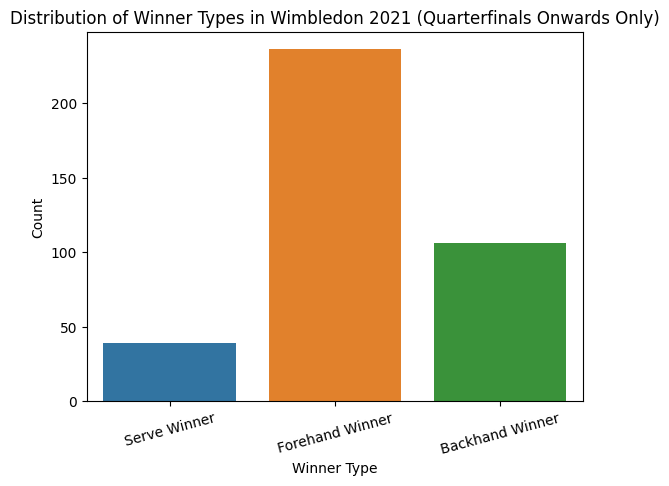

In [9]:
# Create a new column to label winner shot type
def classify_winner(row):
    if row["WinnerType"] == "S":
        return "Serve Winner"
    elif row["WinnerShotType"] == "F":
        return "Forehand Winner"
    elif row["WinnerShotType"] == "B":
        return "Backhand Winner"
    else:
        return None

# Apply classification
qfdraft = qf_points_wimbledon2021_cleaned.copy()
qfdraft["IsWinner"] = qf_points_wimbledon2021_cleaned.apply(classify_winner, axis=1)

# Filter only actual winners
winner_points = qfdraft[qfdraft["IsWinner"].notna()]

# Plot
sns.countplot(data=winner_points, x="IsWinner", order=["Serve Winner", "Forehand Winner", "Backhand Winner"])
plt.title("Distribution of Winner Types in Wimbledon 2021 (Quarterfinals Onwards Only)")
plt.xlabel("Winner Type")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.show()


/Users/barry/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


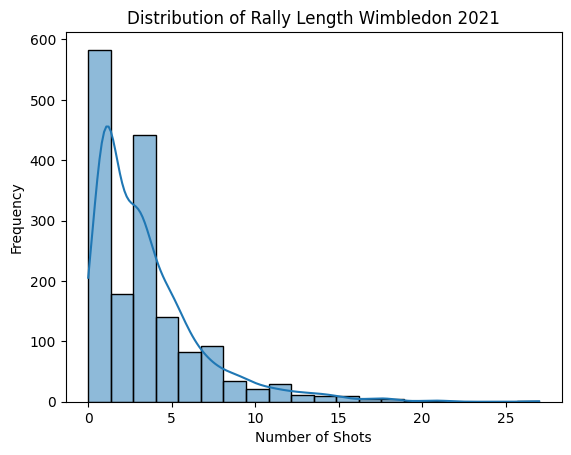

In [10]:
sns.histplot(data=qf_points_wimbledon2021, x="RallyCount", bins=20, kde=True)
plt.title("Distribution of Rally Length Wimbledon 2021")
plt.xlabel("Number of Shots")
plt.ylabel("Frequency")
plt.show()

In [11]:
# sns.boxplot(data=qf_points_usopen2021_cleaned, x="IsWinner", y="RallyCount")
# plt.title("Rally Length by Winner Outcome")
# plt.xlabel("Point Ended in Winner")
# plt.ylabel("Rally Length")
# plt.show()


In [12]:
# qf_points_usopen2019_cleaned.isnull().sum()
# nan_data = qf_points_usopen2019_cleaned[
#     qf_points_usopen2019_cleaned[['ServeWidth', 'ServeDepth', 'ReturnDepth']].isna().all(axis=1)
# ]
# print(nan_data)

### One-hot coding on ServeWidth, ServeDepth, and ReturnDepth

In [13]:
columns = ['ServeWidth', 'ServeDepth', 'ReturnDepth']
categories = [
        ['B', 'BC', 'BW', 'C', 'W', 'Missing'],
        ['CTL', 'NCTL', 'Missing'],
        ['D', 'ND', 'Missing']
    ]
def ohencode_categorical_features(dataframe, columns, categories):
    # Create a copy to preserve original
    cat_encoded = dataframe[columns].copy()

    # Fill missing values with placeholder for categorical encoding
    cat_encoded.fillna('Missing', inplace=True)

    # Initialize OneHotEncoder with known categories
    encoder = OneHotEncoder(
        categories=categories,
        sparse_output=False,
        handle_unknown='ignore'
    )

    # Fit and transform the data
    encoded_array = encoder.fit_transform(cat_encoded)

    # Retrieve new column names
    encoded_columns = encoder.get_feature_names_out(columns)

    # Create encoded DataFrame
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=dataframe.index)
    return encoded_df

In [14]:
qf_points_wimbledon2018_encoded = ohencode_categorical_features(qf_points_wimbledon2018_cleaned, columns, categories)
qf_points_wimbledon2019_encoded = ohencode_categorical_features(qf_points_wimbledon2019_cleaned, columns, categories)
qf_points_wimbledon2021_encoded = ohencode_categorical_features(qf_points_wimbledon2021_cleaned, columns, categories)
qf_points_wimbledon2022_encoded = ohencode_categorical_features(qf_points_wimbledon2022_cleaned, columns, categories)
qf_points_wimbledon2023_encoded = ohencode_categorical_features(qf_points_wimbledon2023_cleaned, columns, categories)

In [15]:

# # Create a copy to preserve original
# cat_encoded = qf_points_usopen2019_cleaned[['ServeWidth', 'ServeDepth', 'ReturnDepth']].copy()

# # Fill missing values with placeholder for categorical encoding
# cat_encoded.fillna('Missing', inplace=True)

# # Initialize OneHotEncoder with known categories
# encoder = OneHotEncoder(
#     categories=[
#         ['B', 'BC', 'BW', 'C', 'W', 'Missing'],
#         ['CTL', 'NCTL', 'Missing'],
#         ['D', 'ND', 'Missing']
#     ],
#     sparse_output =False,
#     handle_unknown='ignore'
# )

# # Fit and transform the data
# encoded_array = encoder.fit_transform(cat_encoded)

# # Retrieve new column names
# encoded_columns = encoder.get_feature_names_out(['ServeWidth', 'ServeDepth', 'ReturnDepth'])

# # Create encoded DataFrame
# encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=qf_points_usopen2019_cleaned.index)
# encoded_df.head()

In [16]:
# qf_encoded.isnull().sum()
# # Count the number of columns in the DataFrame
# print(f"Total columns in qf_encoded: {qf_encoded.shape[1]}")
# qf_encoded.columns
# qf_encoded['IsWinner'].value_counts()

## Selecting Features and Modelling

In [ ]:
# Select relevant features for the model
refined_features = [
    'Speed_KMH',
    # 'P1Momentum', 'P2Momentum',
    'P1Ace', 'P2Ace', 'P1UnfErr', 'P2UnfErr',
    'P1NetPoint', 'P2NetPoint',
    'P1BreakPoint', 'P2BreakPoint',
    'P1BreakPointMissed', 'P2BreakPointMissed',
    'ServeIndicator', 'ServeNumber',
    'P1DistanceRun', 'P2DistanceRun',
    'RallyCount',
    'ServeWidth_B', 'ServeWidth_BC', 'ServeWidth_BW', 'ServeWidth_C', 'ServeWidth_W', 'ServeWidth_Missing',
    'ServeDepth_CTL', 'ServeDepth_NCTL', 'ServeDepth_Missing',
    'ReturnDepth_D', 'ReturnDepth_ND', 'ReturnDepth_Missing',
    'Speed_Width_W', 
    # 'Rally_NetDom',
    # 'MomentumDiff',
    'DistanceDiff', 'AceDiff', 'NetDominance', 'UnfErrDiff'
]


## Prepare data for model

In [ ]:
full_data_p1 = pd.concat([qf_points_wimbledon2018_cleaned.reset_index(drop=True), qf_points_wimbledon2018_encoded.reset_index(drop=True)], axis=1)
full_data_p2 = pd.concat([qf_points_wimbledon2019_cleaned.reset_index(drop=True), qf_points_wimbledon2019_encoded.reset_index(drop=True)], axis=1)
full_data_p4 = pd.concat([qf_points_wimbledon2021_cleaned.reset_index(drop=True), qf_points_wimbledon2021_encoded.reset_index(drop=True)], axis=1)
full_data_p5 = pd.concat([qf_points_wimbledon2022_cleaned.reset_index(drop=True), qf_points_wimbledon2022_encoded.reset_index(drop=True)], axis=1)
# print(full_data_p2.isnull().sum())
# Combine both datasets
test_data = pd.concat([qf_points_wimbledon2023_cleaned.reset_index(drop=True), qf_points_wimbledon2023_encoded.reset_index(drop=True)], axis=1)
full_data = pd.concat([full_data_p1, full_data_p2, full_data_p4, full_data_p5], ignore_index=True)
# # Engineered feature construction
# full_data['MomentumDiff'] = full_data['P1Momentum'] - full_data['P2Momentum']
full_data['DistanceDiff'] = full_data['P1DistanceRun'] - full_data['P2DistanceRun']
full_data['AceDiff'] = full_data['P1Ace'] - full_data['P2Ace']
full_data['NetDominance'] = full_data['P1NetPoint'] - full_data['P2NetPoint']
full_data['UnfErrDiff'] = full_data['P1UnfErr'] - full_data['P2UnfErr']
# Add interaction terms
full_data['Speed_Width_W'] = full_data['Speed_KMH'] * full_data.get('ServeWidth_W', 0)
# full_data['Rally_NetDom'] = full_data['RallyCount'] * full_data['NetDominance']

# Feature engineering for test data
# test_data['MomentumDiff'] = test_data['P1Momentum'] - test_data['P2Momentum']
test_data['DistanceDiff'] = test_data['P1DistanceRun'] - test_data['P2DistanceRun']
test_data['AceDiff'] = test_data['P1Ace'] - test_data['P2Ace']
test_data['NetDominance'] = test_data['P1NetPoint'] - test_data['P2NetPoint']
test_data['UnfErrDiff'] = test_data['P1UnfErr'] - test_data['P2UnfErr']
test_data['Speed_Width_W'] = test_data['Speed_KMH'] * test_data.get('ServeWidth_W', 0)
# test_data['Rally_NetDom'] = test_data['RallyCount'] * test_data['NetDominance']
# Ensure 'IsWinner' is in the final DataFrame
full_data['IsWinner'] = full_data['IsWinner'].astype(int)
test_data['IsWinner'] = test_data['IsWinner'].astype(int)
# Select only the relevant features and the target variable
model_ready_data = full_data[refined_features + ['IsWinner']].dropna()
test_ready_data = test_data[refined_features + ['IsWinner']].dropna()
print(model_ready_data.shape)
# print(test_data.isnull().sum())
print(test_ready_data.shape)
print(test_ready_data.columns)

(7293, 38)
(1591, 38)
Index(['Speed_KMH', 'P1Momentum', 'P2Momentum', 'P1Ace', 'P2Ace', 'P1UnfErr',
       'P2UnfErr', 'P1NetPoint', 'P2NetPoint', 'P1BreakPoint', 'P2BreakPoint',
       'P1BreakPointMissed', 'P2BreakPointMissed', 'ServeIndicator',
       'ServeNumber', 'P1DistanceRun', 'P2DistanceRun', 'RallyCount',
       'ServeWidth_B', 'ServeWidth_BC', 'ServeWidth_BW', 'ServeWidth_C',
       'ServeWidth_W', 'ServeWidth_Missing', 'ServeDepth_CTL',
       'ServeDepth_NCTL', 'ServeDepth_Missing', 'ReturnDepth_D',
       'ReturnDepth_ND', 'ReturnDepth_Missing', 'Speed_Width_W',
       'Rally_NetDom', 'MomentumDiff', 'DistanceDiff', 'AceDiff',
       'NetDominance', 'UnfErrDiff', 'IsWinner'],
      dtype='object')


## Logistic Regression model

In [19]:
X = model_ready_data[refined_features]
y = (model_ready_data['IsWinner']).astype(int)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
tomek = TomekLinks(sampling_strategy='majority')
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
print("Before Tomek:", y_train.value_counts())
print("After Tomek Links:", y_train_tomek.value_counts())
smote = SMOTE(sampling_strategy={1: 6000} ,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tomek, y_train_tomek)
print("After SMOTE:", y_train_resampled.value_counts())
# tomek_post = TomekLinks(sampling_strategy='majority')
# X_final, y_final = tomek_post.fit_resample(X_train_resampled, y_train_resampled)
# print("After Tomek Links Post SMOTE:", y_final.value_counts())
# tomek = TomekLinks()
# X_train_resampled, y_train_resampled = tomek.fit_resample(X_train_smote, y_train_smote)
logreg = LogisticRegression(max_iter=5000, class_weight='balanced', penalty='l1', solver='saga')
logreg.fit(X_train_resampled, y_train_resampled)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
auc = roc_auc_score(y_test, y_prob)
logreg_report_df = pd.DataFrame(report).transpose()
print("Logistic Regression Model Performance:")
print(logreg_report_df)
print("auc score: " + str(auc))


Before Tomek: IsWinner
0    4364
1    1470
Name: count, dtype: int64
After Tomek Links: IsWinner
0    4007
1    1470
Name: count, dtype: int64
After SMOTE: IsWinner
1    6000
0    4007
Name: count, dtype: int64
Logistic Regression Model Performance:
              precision    recall  f1-score     support
0              0.940127  0.676444  0.786780  1091.00000
1              0.476261  0.872283  0.616123   368.00000
accuracy       0.725840  0.725840  0.725840     0.72584
macro avg      0.708194  0.774363  0.701452  1459.00000
weighted avg   0.823128  0.725840  0.743736  1459.00000
auc score: 0.851330550352688


## Visualise LogReg Model result

In [20]:
# coefficients = pd.Series(logreg.coef_[0], index=X.columns).sort_values(ascending=False)
# cm = confusion_matrix(y_test, y_pred)
# coefficients.head(10), coefficients.tail(10), cm

In [21]:
# plt.figure(figsize=(10, 12))
# coefficients.sort_values().plot(kind='barh', color='steelblue')
# plt.title('Logistic Regression Coefficients (Feature Importance)')
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

## Random Forest 

In [22]:
from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
X = model_ready_data[refined_features]
y = (model_ready_data['IsWinner']).astype(int)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
print(X_scaled.shape)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(sampling_strategy = 0.8 ,random_state=42)
tomek = TomekLinks(sampling_strategy='majority')
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tomek, y_train_tomek)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
auc = roc_auc_score(y_test, y_prob)
rf_report_df = pd.DataFrame(report).transpose()
print("Random Forest Model Performance:")
print(rf_report_df)
print("auc score: " + str(auc))

(7293, 37)
Random Forest Model Performance:
              precision    recall  f1-score      support
0              0.953461  0.732356  0.828409  1091.000000
1              0.529791  0.894022  0.665319   368.000000
accuracy       0.773132  0.773132  0.773132     0.773132
macro avg      0.741626  0.813189  0.746864  1459.000000
weighted avg   0.846599  0.773132  0.787273  1459.000000
auc score: 0.8921736141553421


In [23]:
##CODE DUMP
# param_grid = {
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.05, 0.1],
#     'n_estimators': [150, 200],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'min_child_weight': [1, 3],
#     'gamma': [0, 0.1],
#     'scale_pos_weight': [scale_pos_weight]
# }
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring=f1_scorer,
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )
# grid_search.fit(X_train_resampled, y_train_resampled)
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

## xGBoost + lightGradientBM

In [24]:
X = model_ready_data[refined_features]
y = (model_ready_data['IsWinner']).astype(int)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
# scale_pos_weight = (y_train == 1).sum() / (y_train == 0).sum()
print("Before Tomek:", y_train.value_counts())
tomek = TomekLinks(sampling_strategy='majority')
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
print("After Tomek Links:", y_train_tomek.value_counts())
smote = SMOTE(sampling_strategy={1: 6000} ,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tomek, y_train_tomek)
print("After SMOTE:", y_train_resampled.value_counts())
# Apply Tomek Links again to the resampled data
# tomek2 = TomekLinks(sampling_strategy='auto')
# X_train_resampled, y_train_resampled = tomek2.fit_resample(X_train_resampled, y_train_resampled)
# print("After 2 tomek Links:", y_train_resampled.value_counts())
param_dist = {
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.1, 0.2],
    'min_split_gain': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5, 10, 20, 50]
}

f1_scorer = make_scorer(f1_score, pos_label=1)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)
best_params = random_search.best_params_
best_score = random_search.best_score_
# best_params, best_score

# final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
lgbm_model = LGBMClassifier(**best_params, random_state=42)
lgbm_model.fit(X_train_resampled, y_train_resampled)
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
# Finding best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lgbm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold_lgbm = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
# threshold = 0.42  # or re-tune this
y_pred = (y_prob_lgbm >= best_threshold_lgbm).astype(int) #Model prediction using the best threshold
final_report = classification_report(y_test, y_pred, output_dict=True)
lgb_report_df = pd.DataFrame(final_report).transpose()
print("LGBM Model Performance:")
print(lgb_report_df)
auc = roc_auc_score(y_test, y_prob_lgbm)
print("auc score: " + str(auc))

Before Tomek: IsWinner
0    4364
1    1470
Name: count, dtype: int64
After Tomek Links: IsWinner
0    4007
1    1470
Name: count, dtype: int64
After SMOTE: IsWinner
1    6000
0    4007
Name: count, dtype: int64
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas require

[LightGBM] [Info] Number of positive: 4000, number of negative: 2671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3469
[LightGBM] [Info] Number of data points in the train set: 6671, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.599610 -> initscore=0.403841
[LightGBM] [Info] Start training from score 0.403841
[LightGBM] [Info] Number of positive: 4000, number of negative: 2671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3820
[LightGBM] [Info] Number of data points in the train set: 6671, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.599610 -> initscore=0.403841
[LightGBM] 

In [25]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)
best_params = random_search.best_params_
xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
# Finding best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold_xgb = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
# threshold = 0.42  # or re-tune this
y_pred = (y_prob_xgb >= best_threshold_xgb).astype(int) #Model prediction using the best threshold
final_report = classification_report(y_test, y_pred, output_dict=True)
xgb_report_df = pd.DataFrame(final_report).transpose()
print("XGBoost Model Performance:")
print(xgb_report_df)
auc = roc_auc_score(y_test, y_prob_xgb)
print("auc score: " + str(auc))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=10, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=10, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, min_split_gain=0, n_estimators=300, scale_pos_weight=20, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   0.3s


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0.2, n_estimators=200, scale_pos_weight=20, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0.2, n_estimators=200, scale_pos_weight=20, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0.2, n_estimators=200, scale_pos_weight=20, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=10, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=10, subsample=1.0; total time=   0.7s


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=10, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=20, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=20, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=5, min_split_gain=0.2, n_estimators=1

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.3s


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.3s


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.3s


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=3, min_split_gain=0.2, n_estimators=300, scale_pos_weight=20, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=3, min_split_gain=0.2, n_estimators=300, scal

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=10, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=10, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=10, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, min_child_weight=1, min_split_gain=0.1, n_estimators=100, scale_pos_weight=5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, min_child_weight=1, min_split_gain=0.1, n_estimators=100, sc

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0.1, n_estimators=100, scale_pos_weight=10, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, min_split_gain=0.2, n_estimators=300, scale_pos_weight=2, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=20, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, min_split_gain=0.2, n_estimators=300, scale_pos_weight=2, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=20, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=10

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=2, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=2, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_po

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=10, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=10, subsample=1.0; total time=   0.1s
XGBoost Model Performance:
              precision    recall  f1-score      support
0              0.943169  0.791017  0.860419  1091.000000
1              0.580882  0.858696  0.692982   368.000000
accuracy       0.808088  0.808088  0.808088     0.808088
macro avg      0.762026  0.824857  0.776701  1459.000000
weighted avg   0.851791  0.808088  0.818187  1459.000000
auc score: 0.8979122663691069


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Model Comparision (Validation set)

In [26]:
# Extract relevant rows and columns from each classification report
models = {
    'Logistic Regression': logreg_report_df,
    'Random Forest': rf_report_df,
    'XGBoost': xgb_report_df,
    'LightGBM': lgb_report_df
}

# Build long-form rows for class 0 and class 1
rows = []
for model_name, report_df in models.items():
    for label in ['0', '1', 'accuracy']:
        row = report_df.loc[label, ['precision', 'recall', 'f1-score']]
        row.name = (model_name, f'{label}')
        rows.append(row)

# Combine into multi-index DataFrame
comparison_table = pd.DataFrame(rows)
comparison_table.index = pd.MultiIndex.from_tuples(comparison_table.index, names=['Validation Set Model', 'Class'])
comparison_table.columns = ['Precision', 'Recall', 'F1 Score']
comparison_table = comparison_table.round(3)
comparison_table


Precision  Recall  F1 Score
Validation Set Model Class                                
Logistic Regression  0             0.940   0.676     0.787
                     1             0.476   0.872     0.616
                     accuracy      0.726   0.726     0.726
Random Forest        0             0.953   0.732     0.828
                     1             0.530   0.894     0.665
                     accuracy      0.773   0.773     0.773
XGBoost              0             0.943   0.791     0.860
                     1             0.581   0.859     0.693
                     accuracy      0.808   0.808     0.808
LightGBM             0             0.958   0.755     0.845
                     1             0.554   0.902     0.687
                     accuracy      0.792   0.792     0.792

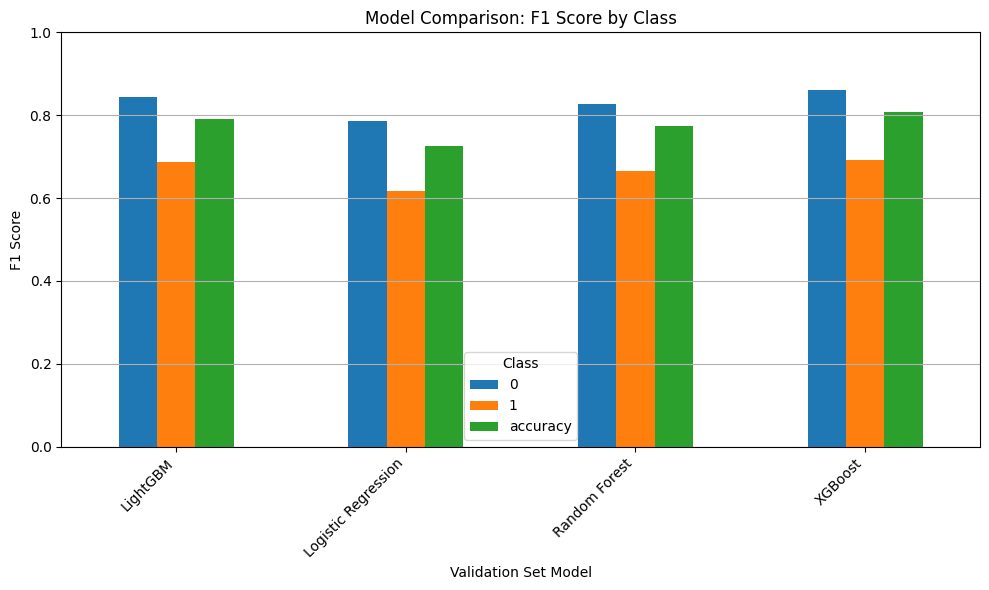

In [27]:
# metrics = pd.DataFrame({
#     'Logistic Regression': logreg_report_df.loc['1', ['precision', 'recall', 'f1-score']],
#     'Random Forest': rf_report_df.loc['1', ['precision', 'recall', 'f1-score']],
#     'XGBoost': xgb_report_df.loc['1', ['precision', 'recall', 'f1-score']],
#     'LightGBM': lgb_report_df.loc['1', ['precision', 'recall', 'f1-score']]
# })
# metrics = metrics.T
# metrics.plot(kind='bar', figsize=(10, 6))
# plt.title('Model Comparison on Class 1 (Winner): Precision, Recall, F1 Score')
# plt.ylabel('Score')
# plt.ylim(0, 1)
# plt.grid(axis='y')
# plt.legend(title='Metric')
# plt.tight_layout()
# plt.show()
# Reset and melt again
# plot_df = comparison_table.reset_index()
# plot_long_model = plot_df.melt(id_vars=['Model', 'Class'], var_name='Metric', value_name='Score')

# plt.figure(figsize=(12, 6))
# sns.catplot(data=plot_long_model, x='Model', y='Score', hue='Class', col='Metric',
#             kind='bar', height=5, aspect=1.2, palette='Set2')

# plt.subplots_adjust(top=0.85)
# plt.suptitle('Performance by Model and Class')
# plt.tight_layout()
# plt.show()
f1_scores = comparison_table['F1 Score'].unstack(level=1)

# Plot
f1_scores.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e','#2ca02c'])
plt.title('Model Comparison: F1 Score by Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

/var/folders/h9/ww6bv2_56t3_2t6n6zljbkr40000gn/T/ipykernel_50941/673772220.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = val_df.groupby('RallyBin').agg({


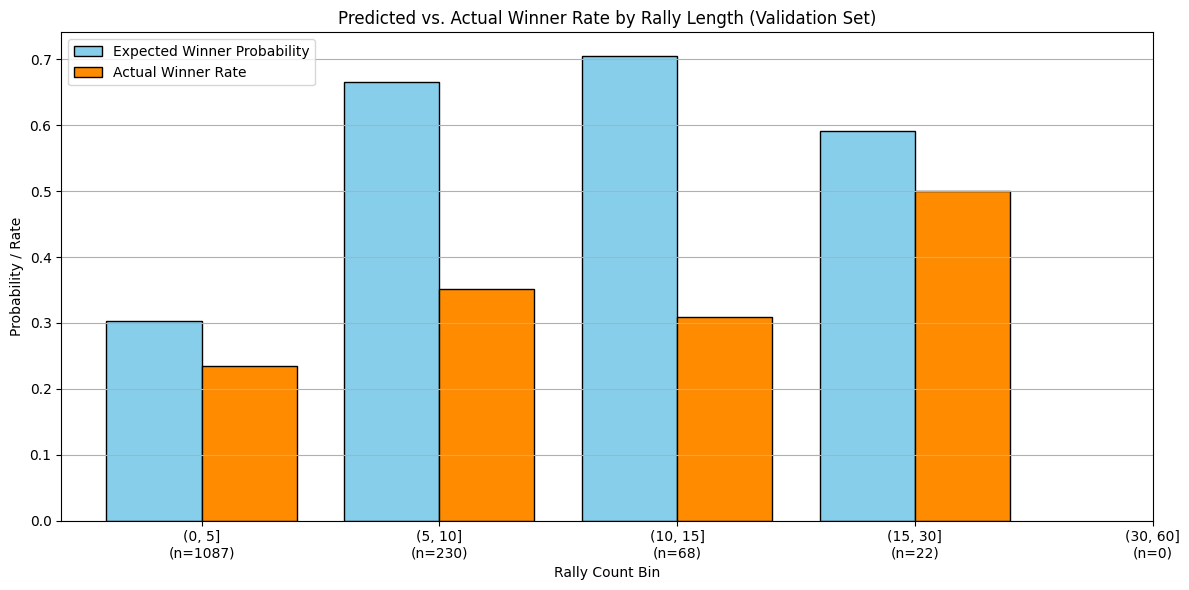

In [28]:
val_df = X_test.copy()
val_df['XWinner'] = y_pred
val_df['RallyCount'] = model_ready_data.loc[X_test.index, 'RallyCount'].values
val_df['RallyBin'] = pd.cut(val_df['RallyCount'], bins=[0, 5, 10, 15, 30, 60])
val_df['IsWinner'] = y_test
# print(val_df[val_df['RallyCount'] > 50]) 
# print(val_df['RallyBin'].value_counts())
# print(val_df.shape)
# print(val_df['RallyCount'].value_counts())
bin_summary = val_df.groupby('RallyBin').agg({
    'XWinner': 'mean',
    'IsWinner': 'mean'
})
bin_counts = val_df['RallyBin'].value_counts().sort_index()
labels_with_counts = [f"{bin}\n(n={count})" for bin, count in zip(bin_summary.index, bin_counts)]
plt.figure(figsize=(12, 6))
bar_width = 0.4

plt.bar(
    x=np.arange(len(bin_summary)) - bar_width / 2,
    height=bin_summary['XWinner'],
    width=bar_width,
    label='Expected Winner Probability',
    color='skyblue',
    edgecolor='black'
)
plt.bar(
    x=np.arange(len(bin_summary)) + bar_width / 2,
    height=bin_summary['IsWinner'],
    width=bar_width,
    label='Actual Winner Rate',
    color='darkorange',
    edgecolor='black'
)
plt.xticks(ticks=np.arange(len(bin_summary)), labels=labels_with_counts)
plt.ylabel('Probability / Rate')
plt.title('Predicted vs. Actual Winner Rate by Rally Length (Validation Set)')
plt.xlabel('Rally Count Bin')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()



AUC Score: 0.8922


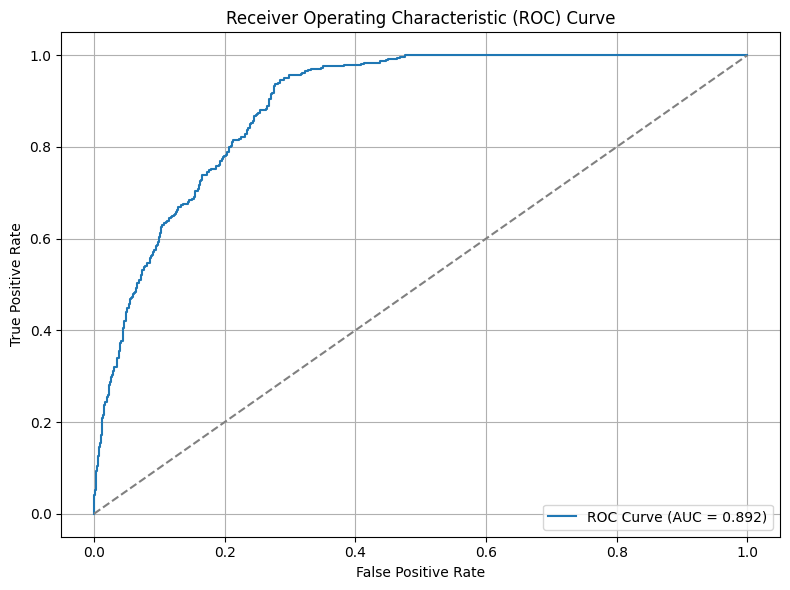

In [29]:
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

P2UnfErr               0.203241
P1UnfErr               0.193598
RallyCount             0.088653
UnfErrDiff             0.069041
P1Ace                  0.038049
P2Ace                  0.034624
AceDiff                0.029739
P1DistanceRun          0.027352
ReturnDepth_Missing    0.026958
P1NetPoint             0.021859
Rally_NetDom           0.019527
ServeIndicator         0.018338
ServeWidth_BC          0.017584
ServeNumber            0.016887
P2NetPoint             0.012446
ServeWidth_BW          0.012241
Speed_KMH              0.012218
P1BreakPoint           0.012108
ReturnDepth_ND         0.011913
P2DistanceRun          0.011860
dtype: float32
NetDominance          0.010133
ServeDepth_NCTL       0.009015
ServeWidth_W          0.008724
P1Momentum            0.008374
P2Momentum            0.008367
ReturnDepth_D         0.008057
P1BreakPointMissed    0.008030
DistanceDiff          0.007261
P2BreakPoint          0.007163
MomentumDiff          0.006915
ServeDepth_CTL        0.006578
P2Br

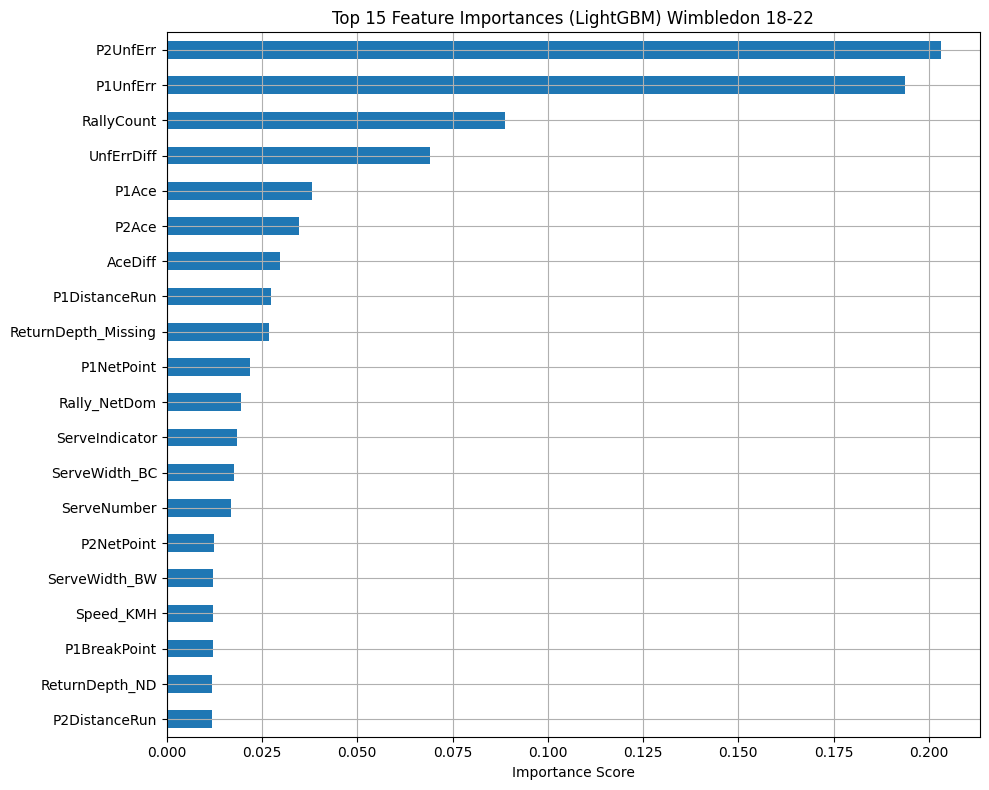

In [30]:
# Get feature importances as a Series
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Sort and select top 15
top_features = feature_importances.sort_values(ascending=False).head(20)
print(top_features)
bot_features = feature_importances.sort_values(ascending=False).tail(15)
print(bot_features)
plt.figure(figsize=(10, 8))
top_features.plot(kind='barh', title='Top 15 Feature Importances (LightGBM) Wimbledon 18-22')
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualizing the results using Precision, Recall and F1 Score vs Threshold

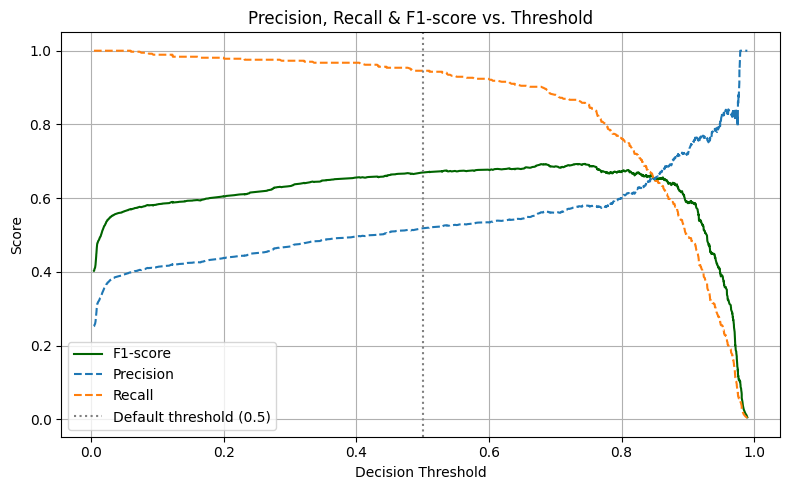

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color='darkgreen')
plt.plot(thresholds, precision[:-1], label="Precision", linestyle='--')
plt.plot(thresholds, recall[:-1], label="Recall", linestyle='--')
plt.axvline(0.5, color='gray', linestyle=':', label='Default threshold (0.5)')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1-score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## TESTING

In [32]:
# Test set prep
X_test = test_ready_data[refined_features]
y_test = (test_ready_data['IsWinner']).astype(int)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
print(X_test_scaled.shape)
# Predict probabilities on the test set using xgb
y_prob_test_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test_xgb = (y_prob_test_xgb >= best_threshold_xgb).astype(int)  #
test_report_xgb = classification_report(y_test, y_pred_test_xgb, output_dict=True)
test_report_df_xgb = pd.DataFrame(test_report_xgb).transpose()
test_auc_xgb = roc_auc_score(y_test, y_prob_test_xgb)
print("Test Set Performance (XGBoost):")
print(test_report_df_xgb)
print("Test AUC Score (XGBoost): " + str(test_auc_xgb))
#Predict probabilities on the test set using lgbm
y_prob_test_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test_lgbm = (y_prob_test_lgbm >= best_threshold_lgbm).astype(int)  #
test_report_lgbm = classification_report(y_test, y_pred_test_lgbm, output_dict=True)
test_report_df_lgbm = pd.DataFrame(test_report_lgbm).transpose()
test_auc_lgbm = roc_auc_score(y_test, y_prob_test_lgbm)
print("Test Set Performance (LightGBM):")
print(test_report_df_lgbm)
print("Test AUC Score (LightGBM): " + str(test_auc_lgbm))
#Predict probabilities on the test set using logreg
y_prob_test_logreg = logreg.predict(X_test_scaled)
test_report_logreg = classification_report(y_test, y_prob_test_logreg, output_dict=True)
test_report_df_logreg = pd.DataFrame(test_report_logreg).transpose()
test_auc_logreg = roc_auc_score(y_test, y_prob_test_logreg)
print("Test Set Performance (Logistic Regression):")
print(test_report_df_logreg)
print("Test AUC Score (Logistic Regression): " + str(test_auc_logreg)) 
# Predict probabilities on the test set using rf
y_prob_test_rf = rf_model.predict(X_test_scaled)
test_report_rf = classification_report(y_test, y_prob_test_rf, output_dict=True)
test_report_df_rf = pd.DataFrame(test_report_rf).transpose()
test_auc_rf = roc_auc_score(y_test, y_prob_test_rf)
print("Test Set Performance (Random Forest):")
print(test_report_df_rf)
print("Test AUC Score (Random Forest): " + str(test_auc_rf))    

(1591, 37)
Test Set Performance (XGBoost):
              precision    recall  f1-score      support
0              0.931238  0.814433  0.868928  1164.000000
1              0.623037  0.836066  0.714000   427.000000
accuracy       0.820239  0.820239  0.820239     0.820239
macro avg      0.777137  0.825249  0.791464  1591.000000
weighted avg   0.848521  0.820239  0.827347  1591.000000
Test AUC Score (XGBoost): 0.9097233958650217
Test Set Performance (LightGBM):
              precision    recall  f1-score      support
0              0.943574  0.775773  0.851485  1164.000000
1              0.588328  0.873536  0.703110   427.000000
accuracy       0.802011  0.802011  0.802011     0.802011
macro avg      0.765951  0.824655  0.777298  1591.000000
weighted avg   0.848231  0.802011  0.811664  1591.000000
Test AUC Score (LightGBM): 0.906216551180215
Test Set Performance (Logistic Regression):
              precision    recall  f1-score      support
0              0.961491  0.664948  0.786186  1164

In [33]:
## Model Comparision on Test Set
# Extract relevant rows and columns from each classification report
models = {
    'Logistic Regression': test_report_df_logreg,
    'Random Forest': test_report_df_rf,
    'XGBoost': test_report_df_xgb,
    'LightGBM': test_report_df_lgbm
}

# Build long-form rows for class 0 and class 1
rows = []
for model_name, report_df in models.items():
    for label in ['0', '1', 'accuracy']:
        row = report_df.loc[label, ['precision', 'recall', 'f1-score']]
        row.name = (model_name, f'{label}')
        rows.append(row)

# Combine into multi-index DataFrame
comparison_table = pd.DataFrame(rows)
comparison_table.index = pd.MultiIndex.from_tuples(comparison_table.index, names=['Test Set Model', 'Class'])
comparison_table.columns = ['Precision', 'Recall', 'F1 Score']
comparison_table = comparison_table.round(3)
comparison_table


Precision  Recall  F1 Score
Test Set Model      Class                                
Logistic Regression 0             0.961   0.665     0.786
                    1             0.504   0.927     0.653
                    accuracy      0.735   0.735     0.735
Random Forest       0             0.948   0.757     0.842
                    1             0.573   0.888     0.696
                    accuracy      0.792   0.792     0.792
XGBoost             0             0.931   0.814     0.869
                    1             0.623   0.836     0.714
                    accuracy      0.820   0.820     0.820
LightGBM            0             0.944   0.776     0.851
                    1             0.588   0.874     0.703
                    accuracy      0.802   0.802     0.802

/var/folders/h9/ww6bv2_56t3_2t6n6zljbkr40000gn/T/ipykernel_50941/3135740963.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = val_df.groupby('RallyBin').agg({


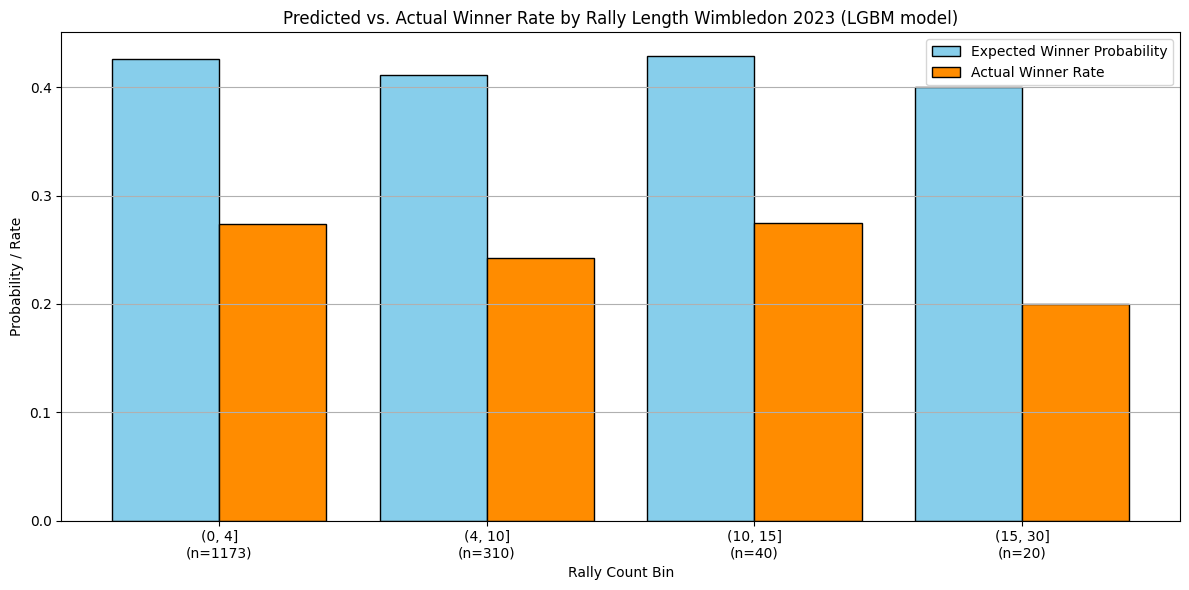

In [34]:
val_df = X_test.copy()
val_df['XWinner'] = y_prob_test_lgbm
val_df['RallyCount'] = model_ready_data.loc[X_test.index, 'RallyCount'].values
val_df['RallyBin'] = pd.cut(val_df['RallyCount'], bins=[0, 4, 10, 15, 30])
val_df['IsWinner'] = y_test
# print(val_df[val_df['RallyCount'] > 50]) 
# print(val_df['RallyBin'].value_counts())
# print(val_df.shape)
# print(val_df['RallyCount'].value_counts())
bin_summary = val_df.groupby('RallyBin').agg({
    'XWinner': 'mean',
    'IsWinner': 'mean'
})
bin_counts = val_df['RallyBin'].value_counts().sort_index()
labels_with_counts = [f"{bin}\n(n={count})" for bin, count in zip(bin_summary.index, bin_counts)]
plt.figure(figsize=(12, 6))
bar_width = 0.4

plt.bar(
    x=np.arange(len(bin_summary)) - bar_width / 2,
    height=bin_summary['XWinner'],
    width=bar_width,
    label='Expected Winner Probability',
    color='skyblue',
    edgecolor='black'
)
plt.bar(
    x=np.arange(len(bin_summary)) + bar_width / 2,
    height=bin_summary['IsWinner'],
    width=bar_width,
    label='Actual Winner Rate',
    color='darkorange',
    edgecolor='black'
)
plt.xticks(ticks=np.arange(len(bin_summary)), labels=labels_with_counts)
plt.ylabel('Probability / Rate')
plt.title('Predicted vs. Actual Winner Rate by Rally Length Wimbledon 2023 (LGBM model)')
plt.xlabel('Rally Count Bin')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

